# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import re
import sys



import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import collections
import math
import classify_image as cl_im

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
FLAGS = tf.app.flags.FLAGS


In [3]:
class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_path=None):
    if not label_path:
      tf.logging.fatal('please specify the label file.')
      return
    self.node_lookup = self.load(label_path)

  def load(self, label_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(label_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(label_path).readlines()
    id_to_human = {}
    for line in proto_as_ascii_lines:
      if line.find(':')<0:
        continue
      _id, human=line.rstrip('\n').split(':')
      id_to_human[int(_id)]=human
    return id_to_human
      
  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

In [4]:
def create_graph(model_file=None):
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  if not model_file:
    #model_file=FLAGS.model_file
    model_file='ckpt/frozen_46860.pb'
  with open(model_file,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')


def run_inference_on_image(image,model_file=None):
  """Runs inference on an image.

  Args:
    image: Image file name.

  Returns:
    Nothing
  """
  if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
  image_data = open(image, 'rb').read()

  # Creates graph from saved GraphDef.
  create_graph(model_file)

  with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('output:0')
    predictions = sess.run(softmax_tensor,
                           {'input:0': image_data})
    predictions = np.squeeze(predictions)

    # Creates node ID --> English string lookup.
    #node_lookup = NodeLookup(FLAGS.label_file)
    node_lookup = NodeLookup('labels.txt')
    top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
    top_names=[]
    for node_id in top_k:
      human_string = node_lookup.id_to_string(node_id)
      top_names.append(human_string)
      score = predictions[node_id]
      print('id:[%d] name:[%s] (score = %.5f)' % (node_id,human_string, score))
  return predictions, top_k, top_names

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '--model_file',
    type=str,
    default='ckpt/frozen_46860.pb',
    help="""\
    Path to the .pb file that contains the frozen weights. \
    """
)
parser.add_argument(
    '--label_file',
    type=str,
    default='labels.txt',
    help='Absolute path to labeltext.'
)
parser.add_argument(
    '--image_file',
    type=str,
    default='',
    help='Absolute path to image file.'
)
parser.add_argument(
    '--num_top_predictions',
    type=int,
    default=5,
    help='Display this many predictions.'
)
FLAGS, unparsed = parser.parse_known_args()
#tf.app.run(main=main,argv=[sys.argv[0]] + unparsed)

In [6]:
#run_inference_on_image(image='test.jpg')

## Object detection imports
Here are the imports from the object detection module.

In [7]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Model preparation 

In [8]:
# What model to download.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'

NUM_CLASSES =3

## Load a (frozen) Tensorflow model into memory.

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [10]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [11]:
category_index

{3: {'id': 3, 'name': 'car'}}

## Helper code

In [12]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [13]:
def find_object_dection_box(boxes,
                            classes,
                            scores):
    min_score_thresh=.4
    box_to_color_map = collections.defaultdict(str)
    for i in range(boxes.shape[0]):
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i].tolist())
            if scores is None:
                box_to_color_map[box] = 'none'
            else:
                if classes[i] in category_index.keys():
                    class_name = category_index[classes[i]]['name']
                else:
                    class_name = 'N/A'
                box_to_color_map[box] = class_name
    return box_to_color_map

# Detection

In [14]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 5) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [15]:
def detect_single_photo(image_path):
   with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        image = Image.open(image_path)
        (im_width, im_height) = image.size
              
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            min_score_thresh=.4,
            use_normalized_coordinates=True,
            line_thickness=8)
        
        ##################################################################################
        box_to_color_map = find_object_dection_box(np.squeeze(boxes),
                                                   np.squeeze(classes).astype(np.int32),
                                                   np.squeeze(scores))           
        object_num = 0
        object_car_num = 0
        for box, className in box_to_color_map.items():
            ymin, xmin, ymax, xmax = box
            object_num = object_num + 1
            if className == 'car':
                imageFileName =  'car' + str(object_num) + '.png'
                print ('imageFileName',imageFileName)
                boxCut = (int(xmin*im_width),int(ymin*im_height),math.ceil(xmax*im_width),math.ceil(ymax*im_height))
                print ('boxCut',boxCut)
                object_car_num = object_car_num + 1
                imageFile = image.crop(boxCut)
                plt.imsave(imageFileName, imageFile)
                #print(imageFileName)
                run_inference_on_image(imageFileName)
        print ('发现的车辆数目为：',object_car_num)
           
        
        ######################################################################################
             
        
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

imageFileName car1.png
boxCut (503, 198, 951, 384)
id:[280] name:[奥迪-Cross] (score = 0.29854)
id:[297] name:[奥迪-S3] (score = 0.22564)
id:[290] name:[奥迪-RS3] (score = 0.15890)
id:[278] name:[奥迪-A7] (score = 0.04410)
id:[373] name:[斯柯达-Superb] (score = 0.03573)
imageFileName car2.png
boxCut (0, 228, 236, 335)
id:[297] name:[奥迪-S3] (score = 0.34163)
id:[747] name:[雷诺-塔利斯曼] (score = 0.08104)
id:[278] name:[奥迪-A7] (score = 0.07769)
id:[198] name:[大众-Jetta] (score = 0.07252)
id:[300] name:[奥迪-SQ5] (score = 0.06543)
发现的车辆数目为： 2


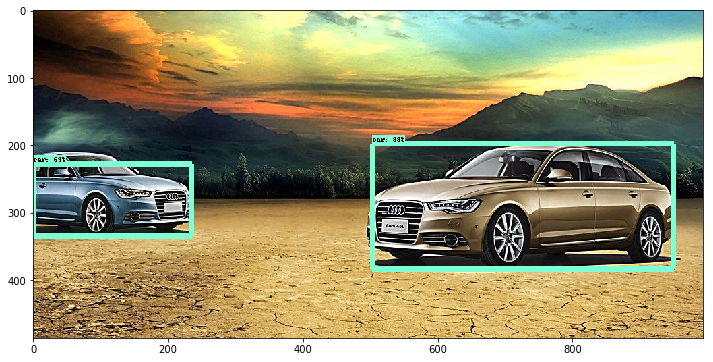

In [16]:
image_path='object_detection/test_images/image4.jpg'
detect_single_photo(image_path)